In [1]:
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error 
from lazypredict.Supervised import LazyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
data= pd.read_csv("/Users/davidthrien/Documents/Ironhack/Ironhack_labs/Final Project/Power Price Forecast DA/Data/14da_windunit_forecast_20250417_0953.csv")
df= data.copy()

In [3]:
df.head(3)

,Datetime,Date,Settlement_Period,Generator_Name,Generator_Full_Name,Region,Capacity,Wind_Forecast
0,2025-04-17T09:00:00Z,2025-04-17,21,ABRBO-1,Aberdeen Bay,NORTH SEA - NORTH SCOTLAND,95.00,12.26
1,2025-04-17T09:00:00Z,2025-04-17,21,ABRTW-1,Auchrobert,SOUTH SCOTLAND,34.00,11.37
2,2025-04-17T09:00:00Z,2025-04-17,21,ACHLW-1,Achlachan,NORTH SCOTLAND,10.25,1.82


In [4]:
df.shape

(162846, 8)

In [5]:
duplicate_rows = df.duplicated().sum()
duplicate_rows

np.int64(0)

In [6]:
df.columns = [column.lower().replace(' ', '_') for column in df.columns]

In [7]:
nan_values = df.isna().sum()
nan_values

datetime                  0
date                      0
settlement_period         0
generator_name            0
generator_full_name       0
region                 1308
capacity                  0
wind_forecast             0
dtype: int64

In [8]:
empty_spaces = df.eq(' ').sum()
empty_spaces

datetime               0
date                   0
settlement_period      0
generator_name         0
generator_full_name    0
region                 0
capacity               0
wind_forecast          0
dtype: int64

In [9]:
df.dtypes

datetime                object
date                    object
settlement_period        int64
generator_name          object
generator_full_name     object
region                  object
capacity               float64
wind_forecast          float64
dtype: object

In [10]:
df['datetime'] = pd.to_datetime(df['datetime'])

df = df[df['datetime'].dt.minute != 30] #only keep hourly values

df = df.reset_index(drop=True)

In [11]:
df.tail(5)

,datetime,date,settlement_period,generator_name,generator_full_name,region,capacity,wind_forecast
81418,2025-04-30 23:00:00+00:00,2025-05-01,1,WLNYO-3,Walney 3,IRISH SEA - NORTH WEST ENGLAND,294.00,100.42
81419,2025-04-30 23:00:00+00:00,2025-05-01,1,WLNYO-4,Walney 4,IRISH SEA - NORTH WEST ENGLAND,311.00,110.45
81420,2025-04-30 23:00:00+00:00,2025-05-01,1,WLNYW-1,Walney 1,IRISH SEA - NORTH WEST ENGLAND,174.00,48.48
81421,2025-04-30 23:00:00+00:00,2025-05-01,1,WTGRW-1,Wathegar,NORTH SCOTLAND,19.00,4.73
81422,2025-04-30 23:00:00+00:00,2025-05-01,1,WTMSO-1,Westermost Rough,NORTH SEA - YORKSHIRE & HUMBER,206.00,87.22


In [12]:
df['load_factor'] = df['wind_forecast'] / df['capacity']
df

,datetime,date,settlement_period,generator_name,generator_full_name,region,capacity,wind_forecast,load_factor
0,2025-04-17 09:00:00+00:00,2025-04-17,21,ABRBO-1,Aberdeen Bay,NORTH SEA - NORTH SCOTLAND,95.00,12.26,0.13
1,2025-04-17 09:00:00+00:00,2025-04-17,21,ABRTW-1,Auchrobert,SOUTH SCOTLAND,34.00,11.37,0.33
2,2025-04-17 09:00:00+00:00,2025-04-17,21,ACHLW-1,Achlachan,NORTH SCOTLAND,10.25,1.82,0.18
3,2025-04-17 09:00:00+00:00,2025-04-17,21,ACHRW-1,A-Chruach,NORTH SCOTLAND,42.00,5.21,0.12
4,2025-04-17 09:00:00+00:00,2025-04-17,21,ACHYW-1,Achany,NORTH SCOTLAND,38.00,3.75,0.10
...,...,...,...,...,...,...,...,...,...
81418,2025-04-30 23:00:00+00:00,2025-05-01,1,WLNYO-3,Walney 3,IRISH SEA - NORTH WEST ENGLAND,294.00,100.42,0.34
81419,2025-04-30 23:00:00+00:00,2025-05-01,1,WLNYO-4,Walney 4,IRISH SEA - NORTH WEST ENGLAND,311.00,110.45,0.36
81420,2025-04-30 23:00:00+00:00,2025-05-01,1,WLNYW-1,Walney 1,IRISH SEA - NORTH WEST ENGLAND,174.00,48.48,0.28
81421,2025-04-30 23:00:00+00:00,2025-05-01,1,WTGRW-1,Wathegar,NORTH SCOTLAND,19.00,4.73,0.25


In [13]:
df_pivot = df.pivot_table(index='datetime', columns='generator_full_name', values='load_factor', aggfunc='first')
df_pivot

generator_full_name,A-Chruach,Aberdeen Bay,Achany,Achlachan,Afton,Aikengall 1,Aikengall 2,Aikengall 3,Airies,An Suidhe,...,Walney 4,Wathegar,West of Duddon Sands 1,West of Duddon Sands 2,Westermost Rough,Wether Hill,Whitelee 1,Whitelee 2,Whiteside Hill,Windy Rig
datetime,,,,,,,,,,,,,,,,,,,,,
2025-04-17 09:00:00+00:00,0.12,0.13,0.10,0.18,0.23,0.51,0.67,0.62,0.11,0.09,...,0.11,0.20,0.08,0.07,0.09,0.19,0.20,0.15,0.47,0.26
2025-04-17 10:00:00+00:00,0.12,0.10,0.15,0.19,0.19,0.38,0.65,0.60,0.11,0.10,...,0.09,0.23,0.06,0.05,0.10,0.20,0.18,0.16,0.46,0.25
2025-04-17 11:00:00+00:00,0.11,0.06,0.11,0.35,0.20,0.30,0.55,0.54,0.09,0.08,...,0.07,0.31,0.05,0.04,0.10,0.24,0.15,0.13,0.35,0.23
2025-04-17 12:00:00+00:00,0.10,0.05,0.13,0.32,0.22,0.38,0.55,0.54,0.09,0.10,...,0.05,0.35,0.03,0.02,0.09,0.20,0.14,0.12,0.39,0.15
2025-04-17 13:00:00+00:00,0.10,0.05,0.16,0.24,0.24,0.44,0.59,0.52,0.09,0.08,...,0.04,0.30,0.02,0.01,0.08,0.27,0.14,0.12,0.30,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30 19:00:00+00:00,0.17,0.22,0.23,0.25,0.24,0.23,0.30,0.23,0.16,0.22,...,0.35,0.26,0.33,0.33,0.40,0.23,0.15,0.14,0.31,0.20
2025-04-30 20:00:00+00:00,0.16,0.22,0.22,0.25,0.23,0.23,0.31,0.24,0.15,0.21,...,0.35,0.25,0.33,0.33,0.41,0.22,0.15,0.13,0.30,0.19
2025-04-30 21:00:00+00:00,0.16,0.22,0.21,0.24,0.23,0.24,0.32,0.24,0.15,0.20,...,0.35,0.25,0.33,0.33,0.41,0.21,0.14,0.13,0.29,0.18


In [14]:
df_pivot['average_load_factor'] = df_pivot.mean(axis=1)

In [15]:
df_pivot

generator_full_name,A-Chruach,Aberdeen Bay,Achany,Achlachan,Afton,Aikengall 1,Aikengall 2,Aikengall 3,Airies,An Suidhe,...,Wathegar,West of Duddon Sands 1,West of Duddon Sands 2,Westermost Rough,Wether Hill,Whitelee 1,Whitelee 2,Whiteside Hill,Windy Rig,average_load_factor
datetime,,,,,,,,,,,,,,,,,,,,,
2025-04-17 09:00:00+00:00,0.12,0.13,0.10,0.18,0.23,0.51,0.67,0.62,0.11,0.09,...,0.20,0.08,0.07,0.09,0.19,0.20,0.15,0.47,0.26,0.17
2025-04-17 10:00:00+00:00,0.12,0.10,0.15,0.19,0.19,0.38,0.65,0.60,0.11,0.10,...,0.23,0.06,0.05,0.10,0.20,0.18,0.16,0.46,0.25,0.14
2025-04-17 11:00:00+00:00,0.11,0.06,0.11,0.35,0.20,0.30,0.55,0.54,0.09,0.08,...,0.31,0.05,0.04,0.10,0.24,0.15,0.13,0.35,0.23,0.14
2025-04-17 12:00:00+00:00,0.10,0.05,0.13,0.32,0.22,0.38,0.55,0.54,0.09,0.10,...,0.35,0.03,0.02,0.09,0.20,0.14,0.12,0.39,0.15,0.14
2025-04-17 13:00:00+00:00,0.10,0.05,0.16,0.24,0.24,0.44,0.59,0.52,0.09,0.08,...,0.30,0.02,0.01,0.08,0.27,0.14,0.12,0.30,0.18,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30 19:00:00+00:00,0.17,0.22,0.23,0.25,0.24,0.23,0.30,0.23,0.16,0.22,...,0.26,0.33,0.33,0.40,0.23,0.15,0.14,0.31,0.20,0.26
2025-04-30 20:00:00+00:00,0.16,0.22,0.22,0.25,0.23,0.23,0.31,0.24,0.15,0.21,...,0.25,0.33,0.33,0.41,0.22,0.15,0.13,0.30,0.19,0.26
2025-04-30 21:00:00+00:00,0.16,0.22,0.21,0.24,0.23,0.24,0.32,0.24,0.15,0.20,...,0.25,0.33,0.33,0.41,0.21,0.14,0.13,0.29,0.18,0.25


In [16]:
df_pivot.reset_index()

generator_full_name,datetime,A-Chruach,Aberdeen Bay,Achany,Achlachan,Afton,Aikengall 1,Aikengall 2,Aikengall 3,Airies,...,Wathegar,West of Duddon Sands 1,West of Duddon Sands 2,Westermost Rough,Wether Hill,Whitelee 1,Whitelee 2,Whiteside Hill,Windy Rig,average_load_factor
0,2025-04-17 09:00:00+00:00,0.12,0.13,0.10,0.18,0.23,0.51,0.67,0.62,0.11,...,0.20,0.08,0.07,0.09,0.19,0.20,0.15,0.47,0.26,0.17
1,2025-04-17 10:00:00+00:00,0.12,0.10,0.15,0.19,0.19,0.38,0.65,0.60,0.11,...,0.23,0.06,0.05,0.10,0.20,0.18,0.16,0.46,0.25,0.14
2,2025-04-17 11:00:00+00:00,0.11,0.06,0.11,0.35,0.20,0.30,0.55,0.54,0.09,...,0.31,0.05,0.04,0.10,0.24,0.15,0.13,0.35,0.23,0.14
3,2025-04-17 12:00:00+00:00,0.10,0.05,0.13,0.32,0.22,0.38,0.55,0.54,0.09,...,0.35,0.03,0.02,0.09,0.20,0.14,0.12,0.39,0.15,0.14
4,2025-04-17 13:00:00+00:00,0.10,0.05,0.16,0.24,0.24,0.44,0.59,0.52,0.09,...,0.30,0.02,0.01,0.08,0.27,0.14,0.12,0.30,0.18,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,2025-04-30 19:00:00+00:00,0.17,0.22,0.23,0.25,0.24,0.23,0.30,0.23,0.16,...,0.26,0.33,0.33,0.40,0.23,0.15,0.14,0.31,0.20,0.26
323,2025-04-30 20:00:00+00:00,0.16,0.22,0.22,0.25,0.23,0.23,0.31,0.24,0.15,...,0.25,0.33,0.33,0.41,0.22,0.15,0.13,0.30,0.19,0.26
324,2025-04-30 21:00:00+00:00,0.16,0.22,0.21,0.24,0.23,0.24,0.32,0.24,0.15,...,0.25,0.33,0.33,0.41,0.21,0.14,0.13,0.29,0.18,0.25
325,2025-04-30 22:00:00+00:00,0.15,0.22,0.20,0.24,0.22,0.25,0.34,0.25,0.15,...,0.25,0.33,0.33,0.42,0.20,0.14,0.13,0.27,0.18,0.25


In [17]:
df_pivot.corr()['average_load_factor'].sort_values(ascending=True)

generator_full_name
Viking 4                 -0.05
Viking 2                 -0.05
Viking 3                 -0.05
Viking 1                 -0.05
Causeymire               -0.01
                          ... 
Whitelee 1                0.91
East Anglia One Part 1    0.91
average_load_factor       1.00
Hornsea B2                 NaN
Walney 2                   NaN
Name: average_load_factor, Length: 246, dtype: float64

In [18]:
print(df_pivot.columns)

Index(['A-Chruach', 'Aberdeen Bay', 'Achany', 'Achlachan', 'Afton',
       'Aikengall 1', 'Aikengall 2', 'Aikengall 3', 'Airies', 'An Suidhe',
       ...
       'Wathegar', 'West of Duddon Sands 1', 'West of Duddon Sands 2',
       'Westermost Rough', 'Wether Hill', 'Whitelee 1', 'Whitelee 2',
       'Whiteside Hill', 'Windy Rig', 'average_load_factor'],
      dtype='object', name='generator_full_name', length=246)


In [19]:
zero_counts = (df_pivot == 0).sum()
columns_with_many_zeros = zero_counts[zero_counts > 10].index.tolist()
columns_with_many_zeros

['Crossdykes',
 'Crossdykes 2',
 'Ewe Hill',
 'Hadyard Hill',
 'Hare Hill Ext',
 'Hornsea B2',
 'Viking 1',
 'Viking 2',
 'Viking 3',
 'Viking 4',
 'Walney 2']

In [20]:
df_pivot = df_pivot.drop(columns=columns_with_many_zeros)

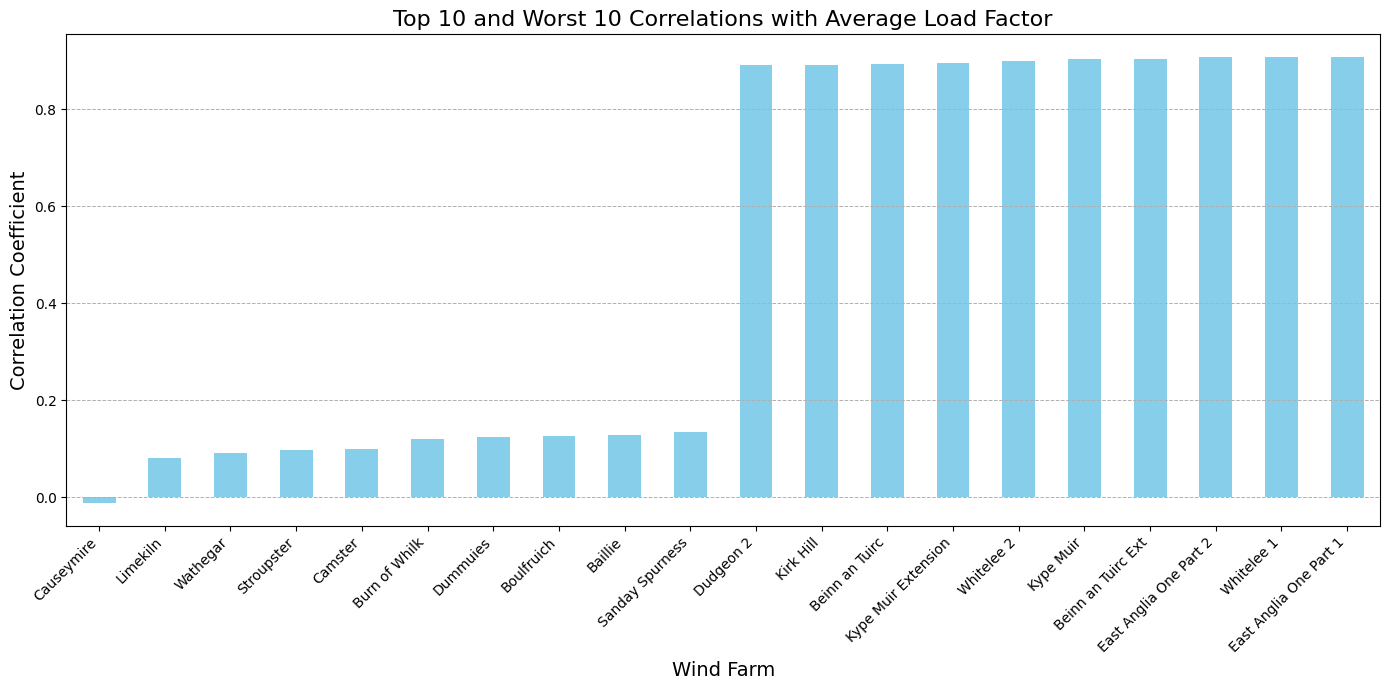

In [21]:
correlations = df_pivot.corr()['average_load_factor'].sort_values(ascending=True)
correlations_with_avg = correlations.drop('average_load_factor')

# Berechne die 10 höchsten und 10 niedrigsten Korrelationen
top_10 = correlations_with_avg.nlargest(10)
worst_10 = correlations_with_avg.nsmallest(10)

# Kombiniere sie in eine Serie
combined = pd.concat([top_10, worst_10])

# Erstelle das Balkendiagramm
plt.figure(figsize=(14, 7))
combined.sort_values().plot(kind='bar', color='skyblue')

plt.title('Top 10 and Worst 10 Correlations with Average Load Factor', fontsize=16)
plt.xlabel('Wind Farm', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)

# Drehung und Ausrichtung der x-Achsenbeschriftungen
plt.xticks(rotation=45, ha='right')

plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()

plt.show()

In [22]:
df_pivot = df_pivot.reset_index()

In [23]:
df_pivot.to_csv('load_factors.csv', index=False)

In [24]:
data_lf= pd.read_csv("/Users/davidthrien/Documents/Ironhack/Ironhack_labs/Final Project/Power Price Forecast DA/load_factors.csv")
df_lf= data_lf.copy()

In [25]:
df_lf.head()

,datetime,A-Chruach,Aberdeen Bay,Achany,Achlachan,Afton,Aikengall 1,Aikengall 2,Aikengall 3,Airies,...,Wathegar,West of Duddon Sands 1,West of Duddon Sands 2,Westermost Rough,Wether Hill,Whitelee 1,Whitelee 2,Whiteside Hill,Windy Rig,average_load_factor
0,2025-04-17 09:00:00+00:00,0.12,0.13,0.10,0.18,0.23,0.51,0.67,0.62,0.11,...,0.20,0.08,0.07,0.09,0.19,0.20,0.15,0.47,0.26,0.17
1,2025-04-17 10:00:00+00:00,0.12,0.10,0.15,0.19,0.19,0.38,0.65,0.60,0.11,...,0.23,0.06,0.05,0.10,0.20,0.18,0.16,0.46,0.25,0.14
2,2025-04-17 11:00:00+00:00,0.11,0.06,0.11,0.35,0.20,0.30,0.55,0.54,0.09,...,0.31,0.05,0.04,0.10,0.24,0.15,0.13,0.35,0.23,0.14
3,2025-04-17 12:00:00+00:00,0.10,0.05,0.13,0.32,0.22,0.38,0.55,0.54,0.09,...,0.35,0.03,0.02,0.09,0.20,0.14,0.12,0.39,0.15,0.14
4,2025-04-17 13:00:00+00:00,0.10,0.05,0.16,0.24,0.24,0.44,0.59,0.52,0.09,...,0.30,0.02,0.01,0.08,0.27,0.14,0.12,0.30,0.18,0.14


In [26]:
df_lf['datetime'] = pd.to_datetime(df_lf['datetime'])
df_lf['date'] = df_lf['datetime'].dt.date
df_lf['hour'] = df_lf['datetime'].dt.hour + 1
df_lf

,datetime,A-Chruach,Aberdeen Bay,Achany,Achlachan,Afton,Aikengall 1,Aikengall 2,Aikengall 3,Airies,...,West of Duddon Sands 2,Westermost Rough,Wether Hill,Whitelee 1,Whitelee 2,Whiteside Hill,Windy Rig,average_load_factor,date,hour
0,2025-04-17 09:00:00+00:00,0.12,0.13,0.10,0.18,0.23,0.51,0.67,0.62,0.11,...,0.07,0.09,0.19,0.20,0.15,0.47,0.26,0.17,2025-04-17,10
1,2025-04-17 10:00:00+00:00,0.12,0.10,0.15,0.19,0.19,0.38,0.65,0.60,0.11,...,0.05,0.10,0.20,0.18,0.16,0.46,0.25,0.14,2025-04-17,11
2,2025-04-17 11:00:00+00:00,0.11,0.06,0.11,0.35,0.20,0.30,0.55,0.54,0.09,...,0.04,0.10,0.24,0.15,0.13,0.35,0.23,0.14,2025-04-17,12
3,2025-04-17 12:00:00+00:00,0.10,0.05,0.13,0.32,0.22,0.38,0.55,0.54,0.09,...,0.02,0.09,0.20,0.14,0.12,0.39,0.15,0.14,2025-04-17,13
4,2025-04-17 13:00:00+00:00,0.10,0.05,0.16,0.24,0.24,0.44,0.59,0.52,0.09,...,0.01,0.08,0.27,0.14,0.12,0.30,0.18,0.14,2025-04-17,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,2025-04-30 19:00:00+00:00,0.17,0.22,0.23,0.25,0.24,0.23,0.30,0.23,0.16,...,0.33,0.40,0.23,0.15,0.14,0.31,0.20,0.26,2025-04-30,20
323,2025-04-30 20:00:00+00:00,0.16,0.22,0.22,0.25,0.23,0.23,0.31,0.24,0.15,...,0.33,0.41,0.22,0.15,0.13,0.30,0.19,0.26,2025-04-30,21
324,2025-04-30 21:00:00+00:00,0.16,0.22,0.21,0.24,0.23,0.24,0.32,0.24,0.15,...,0.33,0.41,0.21,0.14,0.13,0.29,0.18,0.25,2025-04-30,22
325,2025-04-30 22:00:00+00:00,0.15,0.22,0.20,0.24,0.22,0.25,0.34,0.25,0.15,...,0.33,0.42,0.20,0.14,0.13,0.27,0.18,0.25,2025-04-30,23


In [27]:
df_lf.dtypes

datetime               datetime64[ns, UTC]
A-Chruach                          float64
Aberdeen Bay                       float64
Achany                             float64
Achlachan                          float64
                              ...         
Whiteside Hill                     float64
Windy Rig                          float64
average_load_factor                float64
date                                object
hour                                 int32
Length: 238, dtype: object

In [28]:
data_price= pd.read_csv("/Users/davidthrien/Documents/Ironhack/Ironhack_labs/Final Project/Power Price Forecast DA/output.csv")
df_price = data_price.copy()
df_price.dtypes

date                    object
hour                     int64
da_price_prediction    float64
residual_load            int64
dtype: object

In [29]:
df_lf['hour'] = df_lf['hour'].astype(np.int64)
df_lf.dtypes

datetime               datetime64[ns, UTC]
A-Chruach                          float64
Aberdeen Bay                       float64
Achany                             float64
Achlachan                          float64
                              ...         
Whiteside Hill                     float64
Windy Rig                          float64
average_load_factor                float64
date                                object
hour                                 int64
Length: 238, dtype: object

In [30]:
print(df_lf[['date', 'hour']].head())
print(df_price[['date', 'hour']].head())

         date  hour
0  2025-04-17    10
1  2025-04-17    11
2  2025-04-17    12
3  2025-04-17    13
4  2025-04-17    14
         date  hour
0  2025-04-19     1
1  2025-04-19     2
2  2025-04-19     3
3  2025-04-19     4
4  2025-04-19     5


In [31]:
df_lf['date'] = pd.to_datetime(df_lf['date'])
df_price['date'] = pd.to_datetime(df_price['date'])

df_lf['hour'] = df_lf['hour'].astype(int)
df_price['hour'] = df_price['hour'].astype(int)

In [32]:
df_all = pd.merge(df_lf, df_price, on=['date', 'hour'], how='inner')
df_all

,datetime,A-Chruach,Aberdeen Bay,Achany,Achlachan,Afton,Aikengall 1,Aikengall 2,Aikengall 3,Airies,...,Wether Hill,Whitelee 1,Whitelee 2,Whiteside Hill,Windy Rig,average_load_factor,date,hour,da_price_prediction,residual_load
0,2025-04-19 00:00:00+00:00,0.62,0.09,0.17,0.11,0.60,0.24,0.37,0.30,0.51,...,0.58,0.38,0.40,0.52,0.69,0.42,2025-04-19,1,20.90,3785
1,2025-04-19 01:00:00+00:00,0.61,0.09,0.17,0.10,0.62,0.24,0.37,0.30,0.51,...,0.59,0.38,0.40,0.53,0.68,0.41,2025-04-19,2,19.46,4040
2,2025-04-19 02:00:00+00:00,0.60,0.10,0.17,0.11,0.62,0.25,0.38,0.31,0.50,...,0.59,0.40,0.41,0.50,0.68,0.41,2025-04-19,3,18.16,3507
3,2025-04-19 03:00:00+00:00,0.59,0.13,0.19,0.12,0.62,0.25,0.37,0.31,0.51,...,0.60,0.40,0.41,0.52,0.69,0.41,2025-04-19,4,17.33,3128
4,2025-04-19 04:00:00+00:00,0.59,0.13,0.21,0.12,0.62,0.25,0.38,0.32,0.50,...,0.59,0.39,0.41,0.52,0.70,0.42,2025-04-19,5,22.32,2856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2025-04-29 19:00:00+00:00,0.20,0.23,0.29,0.31,0.26,0.28,0.36,0.28,0.16,...,0.24,0.18,0.16,0.34,0.21,0.27,2025-04-29,20,35.09,19464
260,2025-04-29 20:00:00+00:00,0.19,0.23,0.28,0.30,0.26,0.28,0.37,0.28,0.16,...,0.24,0.17,0.16,0.33,0.20,0.27,2025-04-29,21,33.41,20822
261,2025-04-29 21:00:00+00:00,0.19,0.23,0.26,0.30,0.25,0.28,0.37,0.29,0.16,...,0.23,0.17,0.16,0.32,0.20,0.27,2025-04-29,22,29.17,19641
262,2025-04-29 22:00:00+00:00,0.19,0.23,0.25,0.29,0.25,0.29,0.38,0.29,0.16,...,0.22,0.17,0.16,0.31,0.20,0.27,2025-04-29,23,26.61,16713


In [33]:
df_clean = df_all.drop(columns=['datetime', 'average_load_factor', 'date', 'hour', 'residual_load'])
df_clean

,A-Chruach,Aberdeen Bay,Achany,Achlachan,Afton,Aikengall 1,Aikengall 2,Aikengall 3,Airies,An Suidhe,...,Wathegar,West of Duddon Sands 1,West of Duddon Sands 2,Westermost Rough,Wether Hill,Whitelee 1,Whitelee 2,Whiteside Hill,Windy Rig,da_price_prediction
0,0.62,0.09,0.17,0.11,0.60,0.24,0.37,0.30,0.51,0.62,...,0.08,0.82,0.86,0.79,0.58,0.38,0.40,0.52,0.69,20.90
1,0.61,0.09,0.17,0.10,0.62,0.24,0.37,0.30,0.51,0.59,...,0.09,0.84,0.89,0.78,0.59,0.38,0.40,0.53,0.68,19.46
2,0.60,0.10,0.17,0.11,0.62,0.25,0.38,0.31,0.50,0.58,...,0.11,0.86,0.90,0.76,0.59,0.40,0.41,0.50,0.68,18.16
3,0.59,0.13,0.19,0.12,0.62,0.25,0.37,0.31,0.51,0.58,...,0.12,0.86,0.90,0.74,0.60,0.40,0.41,0.52,0.69,17.33
4,0.59,0.13,0.21,0.12,0.62,0.25,0.38,0.32,0.50,0.59,...,0.12,0.86,0.90,0.75,0.59,0.39,0.41,0.52,0.70,22.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0.20,0.23,0.29,0.31,0.26,0.28,0.36,0.28,0.16,0.27,...,0.33,0.32,0.32,0.35,0.24,0.18,0.16,0.34,0.21,35.09
260,0.19,0.23,0.28,0.30,0.26,0.28,0.37,0.28,0.16,0.26,...,0.32,0.31,0.31,0.36,0.24,0.17,0.16,0.33,0.20,33.41
261,0.19,0.23,0.26,0.30,0.25,0.28,0.37,0.29,0.16,0.25,...,0.31,0.31,0.30,0.36,0.23,0.17,0.16,0.32,0.20,29.17
262,0.19,0.23,0.25,0.29,0.25,0.29,0.38,0.29,0.16,0.24,...,0.31,0.30,0.30,0.37,0.22,0.17,0.16,0.31,0.20,26.61


In [34]:
df_multiplied = df_clean.apply(lambda x: x * df_clean['da_price_prediction'] if x.name != 'da_price_prediction' else x)
df_multiplied

,A-Chruach,Aberdeen Bay,Achany,Achlachan,Afton,Aikengall 1,Aikengall 2,Aikengall 3,Airies,An Suidhe,...,Wathegar,West of Duddon Sands 1,West of Duddon Sands 2,Westermost Rough,Wether Hill,Whitelee 1,Whitelee 2,Whiteside Hill,Windy Rig,da_price_prediction
0,12.99,1.84,3.66,2.26,12.47,5.11,7.78,6.37,10.76,12.88,...,1.73,17.12,17.96,16.55,12.15,7.86,8.29,10.87,14.43,20.90
1,11.96,1.82,3.25,1.91,12.06,4.63,7.10,5.81,9.94,11.51,...,1.71,16.40,17.24,15.24,11.56,7.34,7.82,10.23,13.30,19.46
2,10.94,1.89,3.01,1.95,11.25,4.50,6.87,5.64,9.12,10.49,...,1.94,15.59,16.41,13.76,10.73,7.19,7.49,9.03,12.40,18.16
3,10.27,2.28,3.23,2.07,10.83,4.29,6.46,5.29,8.77,10.13,...,2.11,14.88,15.66,12.88,10.38,6.86,7.16,9.05,12.04,17.33
4,13.26,2.92,4.77,2.73,13.74,5.61,8.54,7.08,11.18,13.19,...,2.73,19.12,20.11,16.80,13.07,8.79,9.21,11.72,15.71,22.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,7.03,8.18,10.15,11.02,9.14,9.81,12.71,9.89,5.71,9.52,...,11.60,11.31,11.29,12.42,8.55,6.18,5.61,11.87,7.36,35.09
260,6.51,7.76,9.19,10.16,8.52,9.40,12.31,9.48,5.39,8.65,...,10.77,10.43,10.37,11.93,7.90,5.83,5.29,10.99,6.83,33.41
261,5.57,6.78,7.65,8.61,7.31,8.28,10.93,8.36,4.73,7.24,...,9.18,8.92,8.84,10.57,6.71,5.08,4.61,9.32,5.85,29.17
262,5.04,6.21,6.67,7.66,6.57,7.63,10.14,7.71,4.39,6.37,...,8.18,8.08,8.00,9.83,5.96,4.65,4.22,8.26,5.27,26.61


In [35]:
column_sums= df_multiplied.sum()

df_sums = pd.DataFrame(column_sums, columns=['capture_rate']).T
df_sums

,A-Chruach,Aberdeen Bay,Achany,Achlachan,Afton,Aikengall 1,Aikengall 2,Aikengall 3,Airies,An Suidhe,...,Wathegar,West of Duddon Sands 1,West of Duddon Sands 2,Westermost Rough,Wether Hill,Whitelee 1,Whitelee 2,Whiteside Hill,Windy Rig,da_price_prediction
capture_rate,1551.22,1271.03,1564.03,1578.18,1888.59,1592.00,2110.76,1660.12,1272.48,1860.01,...,1655.57,2066.12,2072.31,2187.01,1672.97,1267.82,1179.10,2108.63,1666.94,6651.42


In [36]:
df_capture_rate = df_sums.apply(lambda x: x / df_sums['da_price_prediction'] if x.name != 'da_price_prediction' else x)
df_capture_rate = df_capture_rate.drop(columns=['da_price_prediction'])
df_capture_rate.reset_index()


,index,A-Chruach,Aberdeen Bay,Achany,Achlachan,Afton,Aikengall 1,Aikengall 2,Aikengall 3,Airies,...,Walney 4,Wathegar,West of Duddon Sands 1,West of Duddon Sands 2,Westermost Rough,Wether Hill,Whitelee 1,Whitelee 2,Whiteside Hill,Windy Rig
0,capture_rate,0.23,0.19,0.24,0.24,0.28,0.24,0.32,0.25,0.19,...,0.35,0.25,0.31,0.31,0.33,0.25,0.19,0.18,0.32,0.25


In [37]:
df_capture_rate.to_csv('capture_rates.csv', index=False)

In [38]:
data_cr= pd.read_csv("/Users/davidthrien/Documents/Ironhack/Ironhack_labs/Final Project/Power Price Forecast DA/capture_rates.csv")
df_cr = data_cr.copy()
df_cr

,A-Chruach,Aberdeen Bay,Achany,Achlachan,Afton,Aikengall 1,Aikengall 2,Aikengall 3,Airies,An Suidhe,...,Walney 4,Wathegar,West of Duddon Sands 1,West of Duddon Sands 2,Westermost Rough,Wether Hill,Whitelee 1,Whitelee 2,Whiteside Hill,Windy Rig
0,0.23,0.19,0.24,0.24,0.28,0.24,0.32,0.25,0.19,0.28,...,0.35,0.25,0.31,0.31,0.33,0.25,0.19,0.18,0.32,0.25


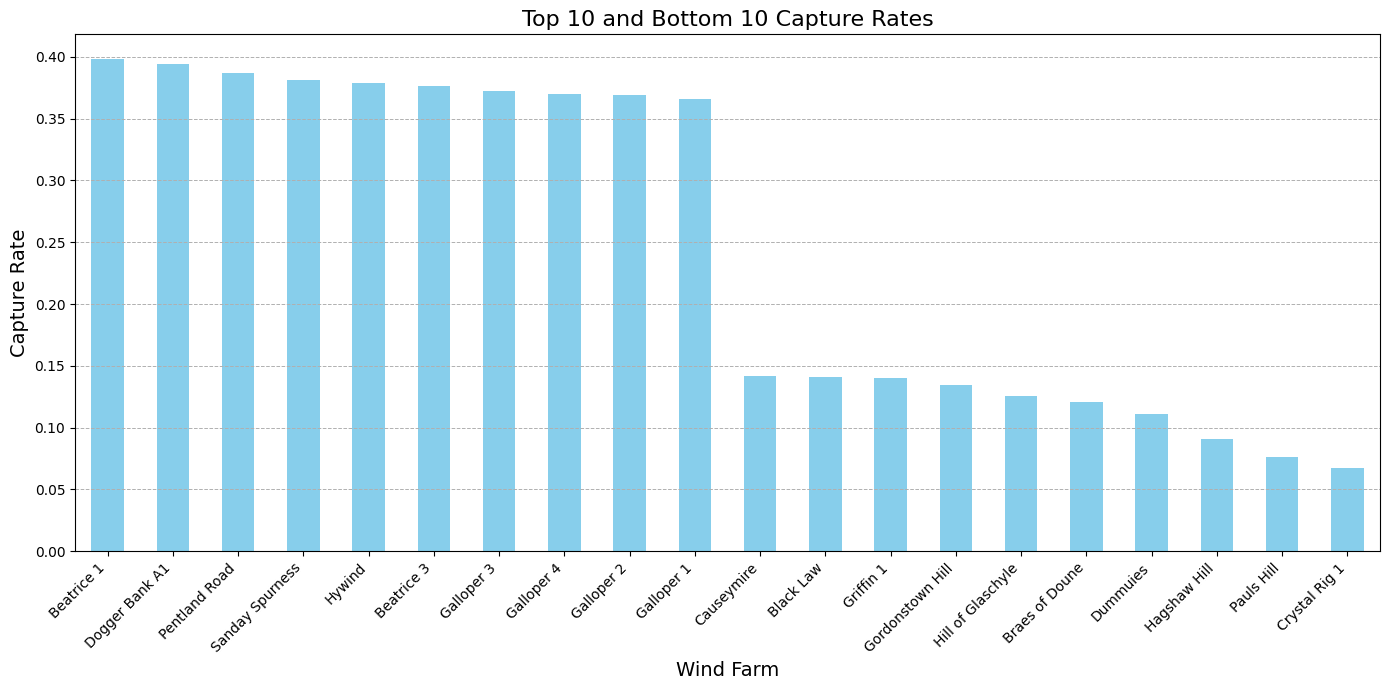

In [39]:
df_transposed = df_cr.T
df_transposed.columns = ['capture_rate']

# Bestimme die 10 größten und 10 kleinsten Werte
top_10 = df_transposed['capture_rate'].nlargest(10)
bottom_10 = df_transposed['capture_rate'].nsmallest(10)


combined = pd.concat([top_10, bottom_10]).sort_values(ascending=False)


plt.figure(figsize=(14, 7))
combined.plot(kind='bar', color='skyblue')

plt.title('Top 10 and Bottom 10 Capture Rates', fontsize=16)
plt.xlabel('Wind Farm', fontsize=14)
plt.ylabel('Capture Rate', fontsize=14)


plt.xticks(rotation=45, ha='right')

plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()